# Mid Semester Project - Reinforcements Learning
Dear students,<br> this is the template notebook. Please copy it by clicking on the "File" tab and then on "Save a copy into drive".

---
<br>

### Name and ID:
Student 1:
<br>
Student 2:
<br><br>
<img src="https://raw.githubusercontent.com/Farama-Foundation/Minigrid/master/minigrid-text.png">

### https://minigrid.farama.org/

# Installs

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install gym-minigrid
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install -U --no-cache-dir gdown --pre

# Imports

In [1]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import pyvirtualdisplay
import imageio
import IPython
import time
from tqdm import tqdm


c:\Users\baruc\anaconda3\envs\NLP\lib\site-packages\gym\envs\registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


# Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

# Env

In [3]:
from __future__ import annotations
from gym_minigrid.minigrid import COLOR_NAMES
from gym_minigrid.minigrid import Grid
from gym_minigrid.minigrid import MissionSpace
from gym_minigrid.minigrid import Door, Goal, Key, Wall, Lava, Floor
from minigrid_x import MiniGridEnv
from gym import spaces
import random


class RandomKeyMEnv_10(MiniGridEnv):
    def __init__(
        self,
        size=10,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        max_steps: int | None = None,
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir

        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            # Set this to True for maximum speed
            see_through_walls=True,
            max_steps=max_steps,
            **kwargs,
        )
        self.partition_col = 3
        self.walls_init = [(self.partition_col, i) for i in range(0, self.grid.height)]
        self.goal_pos = (self.grid.width - 2, self.grid.height - 2)


    def get_pass_location(self):
      return (self.partition_col, self.pass_loc)

    def get_partition_column(self):
      return self.partition_col

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def get_k_pos(self):
      return self.key_pos

    def get_d_pos(self):
      return self.door_pos

    def _gen_grid(self, width, height):
        # Place Dor in random location within all column the partition
        self.pass_loc = random.choice([op_row for op_row in range(1, self.unwrapped.width-1)])

        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Generate verical separation wall
        # for i in range(0, height):
        #     self.grid.set(5, i, Wall())


        for column, row in self.walls_init:
          self.grid.set(column, row, Wall())

        # Place Key in random location within all the free spaces left to the partition
        self.key_pos = (random.choice([k_col for k_col in range(1,self.partition_col)]), random.choice([k_row for k_row in range(2,self.unwrapped.height-1)]))
        self.door_pos = (self.partition_col, self.pass_loc)

        self.env_door = Door(COLOR_NAMES[0], is_locked=True)

        # Place the Lava
        # self.grid.set(4, 6, Lava())

        # Place the door and key
        self.grid.set(self.door_pos[0], self.door_pos[1], self.env_door)
        self.grid.set(self.key_pos[0], self.key_pos[1], Key(COLOR_NAMES[0]))
        self.goal_pos = (width - 2, height - 2)
        # Place a goal square in the bottom-right corner
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"

class RandomEmptyEnv_10(MiniGridEnv):
    def __init__(
        self,
        size=10,
        agent_start_pos=(1, 1),
        agent_start_dir = 0,
        max_steps: int | None = None,
        **kwargs,
    ):

        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir



        agent_start_x_loc =random.randint(1, 6)
        agent_start_y_loc =random.randint(1, 6)

        self.agent_start_pos = (agent_start_x_loc,agent_start_y_loc)


        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            # Set this to True for maximum speed
            see_through_walls=True,
            max_steps=max_steps,
            **kwargs,
        )
        self.action_space = spaces.Discrete(3)
        self.walls_init = []

        # change 21-09 for random env
        self.not_goal_loc = [(col,row) for col in range(self.unwrapped.width) for row in range(self.unwrapped.height) if row == 0 or row == (self.unwrapped.width-1) or col == 0 or col == (self.unwrapped.height-1)]
        self.not_goal_loc.append(self.agent_start_pos)
        self.goal_pos = (self.grid.width - 2, self.grid.height - 2)

    def reset(self, **kwargs):
        # Randomize start position each time environment is reset
        agent_start_x_loc = random.randint(1, 6)
        agent_start_y_loc = random.randint(1, 6)
        self.agent_start_pos = (agent_start_x_loc, agent_start_y_loc)

        self.values = [0, 1, 2, 3]
        self.agent_start_dir = random.choice(self.values)

        # Recalculate not_goal_loc as it depends on the agent's start position
        self.not_goal_loc = [(col, row) for col in range(self.unwrapped.width) for row in range(self.unwrapped.height)
                             if row == 0 or row == (self.unwrapped.width - 1) or col == 0 or col == (self.unwrapped.height - 1)]
        self.not_goal_loc.append(self.agent_start_pos)

        # Call the reset method of the parent class
        return super().reset(**kwargs)

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def get_k_pos(self):
      return self.key_pos

    def get_d_pos(self):
      return self.door_pos

    def get_g_pos(self):
      return self.goal_pos

    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Generate verical separation wall
        # for i in range(0, height):
        #     self.grid.set(5, i, Wall())


        for column, row in self.walls_init:
          self.grid.set(column, row, Wall())

        self.key_pos = (6, 5)
        self.door_pos = (6, 7)

        self.env_door = Door(COLOR_NAMES[0], is_locked=True)

        # Place the Lava
        # self.grid.set(4, 6, Lava())

        # Place the door and key
        # self.grid.set(self.door_pos[0], self.door_pos[1], self.env_door)
        # self.grid.set(self.key_pos[0], self.key_pos[1], Key(COLOR_NAMES[0]))



        ## change 21-09 for random env - add player position
        # self.goal_pos = (0, 0)
        # while self.goal_pos in self.not_goal_loc:
        #   self.goal_pos = (random.randint(1, width - 2), random.randint(1, height - 2))
        self.goal_pos = random.choice([(8,1), (8,8), (1,8)])


        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # Place a goal square in the bottom-right corner
        # self.put_obj(Goal(), width - 2, height - 2)


        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"




# Wrappers

In [4]:
import gym
from gym import spaces
from gym_minigrid.minigrid import OBJECT_TO_IDX, COLOR_TO_IDX
import copy
max_env_steps = 100

class SimFlatObsWrapper(gym.core.ObservationWrapper):
    """Fully observable gridworld returning a flat grid encoding."""

    def __init__(self, env):
        super().__init__(env)

        # Since the outer walls are always present, we remove left, right, top, bottom walls
        # from the observation space of the agent. There are 3 channels, but for simplicity
        # in this assignment, we will deal with flattened version of state.

        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3,),  # number of cells
            dtype='uint8'
        )
        self.unwrapped.max_steps = max_env_steps

        self.get_init_map()

    def observation(self, obs):
        # this method is called in the step() function to get the observation
        # we provide code that gets the grid state and places the agent in it
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])
        full_grid = full_grid[1:-1, 1:-1]   # remove outer walls of the environment (for efficiency)

        flattened_grid = full_grid.ravel()
        return flattened_grid

    def is_carrying_key(self):
        if 'Key' in str(self.unwrapped.carrying):
          return True
        return False

    def is_door_open(self):
        return self.unwrapped.env_door.is_open

    def get_position(self):
        return self.unwrapped.agent_pos

    def get_direction(self):
        return self.unwrapped.agent_dir

    def get_direction_str(self):
        return self.unwrapped.AGENT_DIR_TO_STR[self.unwrapped.agent_dir]

    def is_wall_front_pos(self):
      if 0 in self.unwrapped.front_pos or (self.unwrapped.height-1) in self.unwrapped.front_pos:
        return True
      return (tuple(self.unwrapped.front_pos) in self.unwrapped.walls_init)

    def get_goal_pos(self):
        return self.unwrapped.goal_pos

    def get_init_map(self):
      # outer walls
      map_u = [[1 if i == 0 or i == (self.unwrapped.height-1) or j == 0 or j == (self.unwrapped.width-1) else 0 for j in range(self.unwrapped.width)] for i in range(self.unwrapped.height)]
      # inner walls
      for loc in self.unwrapped.walls_init: map_u[loc[1]][loc[0]] = 1
      self.init_map = map_u

    def get_updated_map(self):
      map_up = copy.deepcopy(self.init_map)
      # agent position
      agent_col, agent_row = self.unwrapped.agent_pos
      map_up[agent_row][agent_col] = 'P'
      # goal
      curr_goal_pos = self.get_goal_pos()
      map_up[curr_goal_pos[1]][curr_goal_pos[0]] = 'G'
      return map_up

    def is_door_front_pos(self):
      return (tuple(self.unwrapped.front_pos) == self.unwrapped.get_d_pos())

    def is_key_front_pos(self):
      return (tuple(self.unwrapped.front_pos) == self.unwrapped.get_k_pos())

    def render(self, *args, **kwargs):
        """This removes the default visualization of the partially observable field of view."""
        return self.unwrapped.render()


class KeyFlatObsWrapper(gym.core.ObservationWrapper):
    """Fully observable gridworld returning a flat grid encoding."""

    def __init__(self, env):
        super().__init__(env)

        # Since the outer walls are always present, we remove left, right, top, bottom walls
        # from the observation space of the agent. There are 3 channels, but for simplicity
        # in this assignment, we will deal with flattened version of state.

        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3,),  # number of cells
            dtype='uint8'
        )
        self.unwrapped.max_steps = max_env_steps

        self.get_init_map()

    def observation(self, obs):
        # this method is called in the step() function to get the observation
        # we provide code that gets the grid state and places the agent in it
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])
        full_grid = full_grid[1:-1, 1:-1]   # remove outer walls of the environment (for efficiency)

        flattened_grid = full_grid.ravel()
        return flattened_grid

    def is_carrying_key(self):
        if 'Key' in str(self.unwrapped.carrying):
          return True
        return False

    def is_door_open(self):
        return self.unwrapped.env_door.is_open

    def get_position(self):
        return self.unwrapped.agent_pos

    def get_direction(self):
        return self.unwrapped.agent_dir

    def get_direction_str(self):
        return self.unwrapped.AGENT_DIR_TO_STR[self.unwrapped.agent_dir]

    def is_wall_front_pos(self):
      if 0 in self.unwrapped.front_pos or (self.unwrapped.height-1) in self.unwrapped.front_pos:
        return True
      return (tuple(self.unwrapped.front_pos) in self.unwrapped.walls_init)

    def get_goal_pos(self):
      return self.unwrapped.goal_pos

    def get_door_pos(self):
      return self.unwrapped.door_pos

    def get_key_pos(self):
      return self.unwrapped.key_pos

    def get_init_map(self):
      # outer walls
      map_u = [[1 if i == 0 or i == (self.unwrapped.height-1) or j == 0 or j == (self.unwrapped.width-1) else 0 for j in range(self.unwrapped.width)] for i in range(self.unwrapped.height)]
      # inner walls
      for loc in self.unwrapped.walls_init: map_u[loc[1]][loc[0]] = 1
      # map_u[self.unwrapped.width-2][self.unwrapped.height-2] = 'G'
      self.init_map = map_u

    def get_updated_map(self):
      map_up = copy.deepcopy(self.init_map)
      # agent position
      agent_col, agent_row = self.unwrapped.agent_pos
      map_up[agent_row][agent_col] = 'P'
      if not self.is_door_open():
        door_col, door_row = self.unwrapped.door_pos
        map_up[door_row][door_col] = 'D'
        if not self.is_carrying_key():
          key_col, key_row = self.unwrapped.key_pos
          map_up[key_row][key_col] = 'K'
      # goal
      curr_goal_pos = self.get_goal_pos()
      map_up[curr_goal_pos[1]][curr_goal_pos[0]] = 'G'

      return map_up

    def is_door_front_pos(self):
      return (tuple(self.unwrapped.front_pos) == self.unwrapped.get_d_pos())

    def is_key_front_pos(self):
      return (tuple(self.unwrapped.front_pos) == self.unwrapped.get_k_pos())

    def render(self, *args, **kwargs):
        """This removes the default visualization of the partially observable field of view."""
        return self.unwrapped.render()



```
# This is formatted as code
```

# RandomEmptyEnv_10

**Description**:

This environment is an empty room, and the goal of the agent is to reach the green goal square.

Agent position at begining is random.


Direction of the agent at begining is random.


Goal position could be: (8,1) or (1,8) or (8,8).

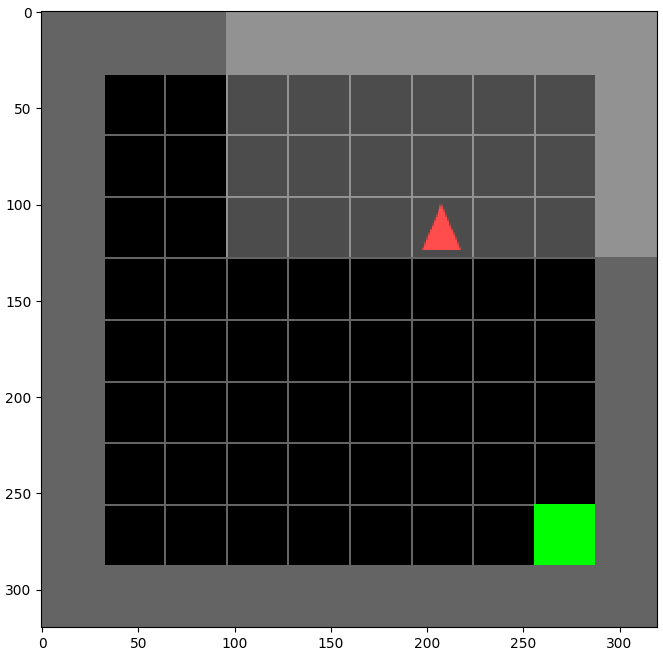

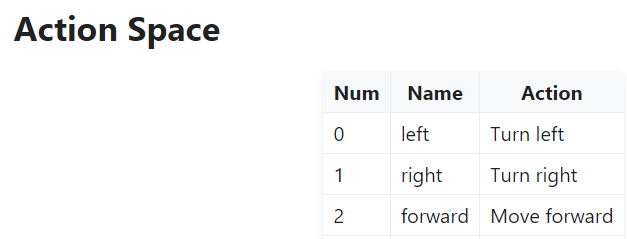

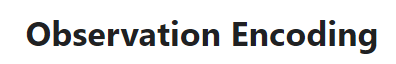

Agent Direction,
Agent Position,
Goal Position

In [ ]:
env = KeyFlatObsWrapper(RandomEmptyEnv_10 (render_mode='rgb_array'))
obs = env.reset()[0]
print(obs)
screen = env.render()
plt.imshow(screen)

In [ ]:
action_space = env.action_space
num_actions = action_space.n
print(f"Number of actions: {num_actions}")


In [ ]:
obs = env.reset()
# ============================================
screen = env.render()
plt.imshow(screen)
print('Map Height:', env.height-2)
print('Map Width:', env.width-2)
print('Agent Direction:', env.get_direction())
print('Agent Position:', env.get_position())
print('Goal position: ', env.get_goal_pos())

In [ ]:
#Random action plus visualization
#env = KeyFlatObsWrapper(RandomEmptyEnv_10 (render_mode='rgb_array'))
obs = env.reset()
video_filename = '/content/fn.mp4'
max_steps = 100

with imageio.get_writer(video_filename, fps=10) as video:
  obs = env.reset()
  done = False
  total_reward = 0
  for step in range(max_steps):
      action = random.randint(0, num_actions - 1)
      obs, reward, done, _, _ = env.step(action)
      next_obs = obs  # Get agent's position directly from the environment
      video.append_data(env.render())
      if done:
        print("done","reward=", total_reward,"num_of_steps=",step)
        break
embed_mp4(video_filename)

# RandomKeyMEnv_10

###Description

This environment has a key that the agent must pick up in order to unlock a goal and then get to the green goal square.

Wall is always in the third column

Key is always in the left part (left to the door)

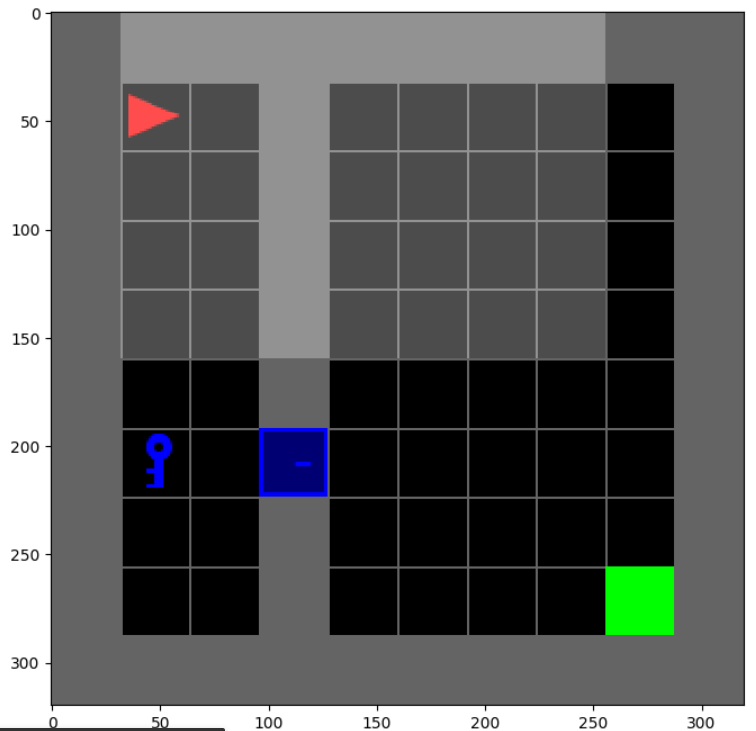

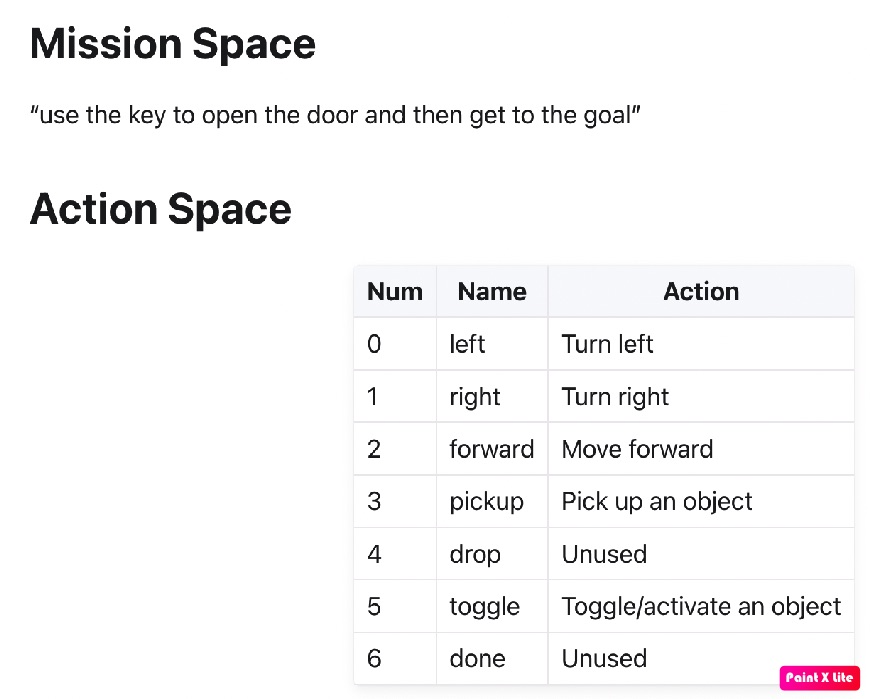

In [ ]:
#=============== DO NOT DELETE ===============
# random.seed(42)
env = KeyFlatObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))
#env = KeyFlatObsWrapper(KeyMazeEnv_10(render_mode='rgb_array'))

obs = env.reset()
# ============================================
screen = env.render()
plt.imshow(screen)

In [ ]:
action_space = env.action_space
num_actions = action_space.n
print(f"Number of actions: {num_actions}")

In [ ]:
env = KeyFlatObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))
obs = env.reset()
# ============================================
screen = env.render()
plt.imshow(screen)
print('Door is opened? : ', env.is_door_open())
print('carrying Key? : ',env.is_carrying_key())
print('Agent Direction:', env.get_direction())
print('Agent Position:', env.get_position())
print('Is there a wall in from of the Agent? : ', env.is_wall_front_pos())
print('Goal position: ', env.get_goal_pos())
print('Key Position:', env.get_k_pos())
print('Door Position:', env.get_d_pos())

# Start of our code

## General methods

In [5]:
# Function to convert state into a hashable type
def hash_state(state):
    # if ndarray, convert to tuple
    if isinstance(state, np.ndarray):
        state = tuple(state)
    else:
        print('Warning: state is not a numpy array, bro you are in trouble (evil laugh)') # just for fun :D
    return state

# Function to implement epsilon-greedy policy
def epsilon_greedy_policy(Q, hashed_state, epsilon, num_actions):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice(num_actions)
    else:
        return np.argmax(Q[hashed_state])

# Function that returns the mean value of every amount_to_avg elements in a list (optional plot)
def mean_list(num_list, amount_to_avg, display=False, list_name="List"):
    # return and avarage list of every amount_to_avg elements
    avg_list = [np.mean(num_list[i:i+amount_to_avg]) for i in range(0, len(num_list), amount_to_avg)]
    # plot mean reward
    if display:
        # define plot size
        plt.figure(figsize=(8, 4))
        plt.plot(avg_list)
        plt.xticks(np.arange(0, len(avg_list), step=1), np.arange(0, len(avg_list)*amount_to_avg, step=amount_to_avg)) # set x-ticks to episode numbers
        plt.xlabel('Episodes')
        plt.ylabel(f"Mean reward per {amount_to_avg} episodes")
        plt.title(f"Mean reward per {amount_to_avg} episodes for {list_name}")
        plt.show()
    # return the average list
    return avg_list

def infer_goal(env, policy, max_steps=1000, show_init_state=True, video_filename=None):
    # reset the environment
    obs = env.reset()[0]
    done = False
    total_reward = 0
    # show the initial state
    if show_init_state:
        screen = env.render()
        plt.imshow(screen)
    # initialize video writer if video_filename is provided
    video = None
    if video_filename is not None:
        video = imageio.get_writer(video_filename, fps=10)
    # run the environment until done or max_steps
    for step in range(max_steps):
        # get the action from the policy
        action = policy[hash_state(obs)]
        # take a step in the environment
        obs, reward, done, _, _ = env.step(action)
        # add the reward to the total
        total_reward += reward
        # record the environment state if video is being recorded
        if video is not None:
            video.append_data(env.render())
        # if done, break
        if done:
            break
    # close the video writer if video was recorded
    if video is not None:
        video.close()
        # display the video
        embed_mp4(video_filename)
    # return the done flag, total reward, and number of steps
    return done, total_reward, step

# Empty Environment

## Monte Carlo

In [6]:
import sys
from collections import defaultdict

# Function to generate an episode following the epsilon-greedy policy
def generate_episode(env, Q, epsilon, max_steps):
    # initialize the episode list, reset the environment, and get the initial state and hashed state
    episode = []
    state = env.reset()[0]
    hashed_state = hash_state(state)
    # loop over the max_steps
    for t in range(max_steps):
        # get the action following the epsilon-greedy policy and take a step in the environment
        action = epsilon_greedy_policy(Q, hashed_state, epsilon, env.action_space.n)
        next_state, reward, done, _, _ = env.step(action)
        # append the state, action, and reward to the episode
        episode.append((hashed_state, action, reward))
        if done:
            break
        # update the current state and hashed state
        state = next_state
        hashed_state = hash_state(state)
    return episode

# Function to update the Q-table based on the generated episode
def update_Q(episode, Q, returns_sum, state_action_count, gamma):
    # get the states, actions, and rewards in the episode
    states, actions, rewards = zip(*episode)
    num_of_steps = len(rewards) + 1
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(num_of_steps)])
    # update the sum of the returns, and the count of returns for each state-action pair in the episode
    for i, (state , action) in enumerate(zip(states, actions)):
        # calculate i_th discounted return
        i_discounted_rewards = rewards[i:] * discounts[:-(1 + i)]
        # update the sum of the returns
        returns_sum[state][action] += sum(i_discounted_rewards)
        # update the count of returns
        state_action_count[state][action] += 1.0
        # update the Q-table
        Q[state][action] = returns_sum[state][action] / state_action_count[state][action]
    return Q

# Main function to implement the Monte Carlo Control with Epsilon-Greedy policy
def mc_control_epsilon_greedy(env, num_episodes, epsilon, gamma=1.0, max_env_steps=1000, print_every=100):
    # init history
    reward_history = []
    num_steps_history = []
    # initialize the Q-table, returns sum, and state-action count
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    state_action_count = defaultdict(lambda: np.zeros(env.action_space.n))

    # loop over the episodes
    for i in range(num_episodes):
        # generate an episode and update the Q-table
        episode = generate_episode(env, Q, epsilon, max_env_steps)
        Q = update_Q(episode, Q, returns_sum, state_action_count, gamma)
        # Calculate total reward for the episode and append into the reward_history list
        curr_reward = sum([reward for _, _, reward in episode])
        reward_history.append(curr_reward)
        # append the number of steps in the episode to the num_steps_history list
        num_steps_history.append(len(episode))

        # Print out the total reward and number of steps in the episode every 'print_every' episodes
        if i % print_every == 0 or i == num_episodes - 1:
            print(f"\rEpisode {i}/{num_episodes}. Avg reward: {np.mean(reward_history[-print_every:])}, Avg steps: {np.mean(num_steps_history[-print_every:])}", end="")
            sys.stdout.flush()

    # get the policy from the Q-table
    policy = {state: np.argmax(values) for state, values in Q.items()}
    # return the policy, Q-table, and the reward history
    return policy, Q, reward_history, num_steps_history



Monte Carlo greed search

In [16]:
# set the random seed
random.seed(42)
# create the environment
env = SimFlatObsWrapper(RandomEmptyEnv_10 (render_mode='rgb_array'))
# set the number of episodes
num_episodes = 1000
max_steps = 1000

# Greed search for hyperparameters
epsilons = [0.2]
gammas = [0.95, 0.99]
best_reward = -float('inf')
best_num_steps = float('inf')
best_params_mc_empty = None
best_policy_mc_empty = None
best_Q_mc_empty = None
best_reward_history_mc_empty = None
best_num_steps_history_mc_empty = None

reward_historys = {}
num_steps_historys = {}

# loop over the hyperparameters
for epsilon in epsilons:
    for gamma in gammas:
        print()
        print(f"Training for epsilon={epsilon}, gamma={gamma}")
        policy, Q, reward_history, num_steps_history = mc_control_epsilon_greedy(env, num_episodes, epsilon, gamma, max_steps)
        print()
        # the best policy is the one that has the highest reward mean in the last 100 episodes + the lowest mean number of steps in the last 100 episodes
        curr_reward = np.mean(reward_history[-100:])
        curr_num_steps = np.mean(num_steps_history[-100:])
        if curr_reward > best_reward or (curr_reward == best_reward and curr_num_steps < best_num_steps):
            best_reward = curr_reward
            best_params_mc_empty = (epsilon, gamma)
            best_policy_mc_empty = policy
            best_Q_mc_empty = Q
            best_reward_history_mc_empty = reward_history
            best_num_steps_history_mc_empty = num_steps_history
            best_num_steps = curr_num_steps
            print(f"New best reward: {best_reward}, epsilon: {epsilon}, gamma: {gamma}")
            print(f"New best number of steps: {best_num_steps}")
        else:
            print(f"Current reward: {curr_reward}, epsilon: {epsilon}, gamma: {gamma}")
            print(f"Current number of steps: {curr_num_steps}")
        print()

        # add the reward history and number of steps history to the dictionary
        reward_historys[(epsilon, gamma)] = reward_history
        num_steps_historys[(epsilon, gamma)] = num_steps_history

# print the best parameters
print(f"Best parameters: epsilon={best_params_mc_empty[0]}, gamma={best_params_mc_empty[1]}, reward={best_reward}, num_steps={best_num_steps}")


Training for epsilon=0.2, gamma=0.95
Episode 999/1000. Avg reward: 1.0, Avg steps: 23.6105
New best reward: 1.0, epsilon: 0.2, gamma: 0.95
New best number of steps: 23.61


Training for epsilon=0.2, gamma=0.99
Episode 999/1000. Avg reward: 1.0, Avg steps: 26.6208
Current reward: 1.0, epsilon: 0.2, gamma: 0.99
Current number of steps: 26.62

Best parameters: epsilon=0.2, gamma=0.95, reward=1.0, num_steps=23.61


monte carlo plot greed search results (reward history and number of steps history)

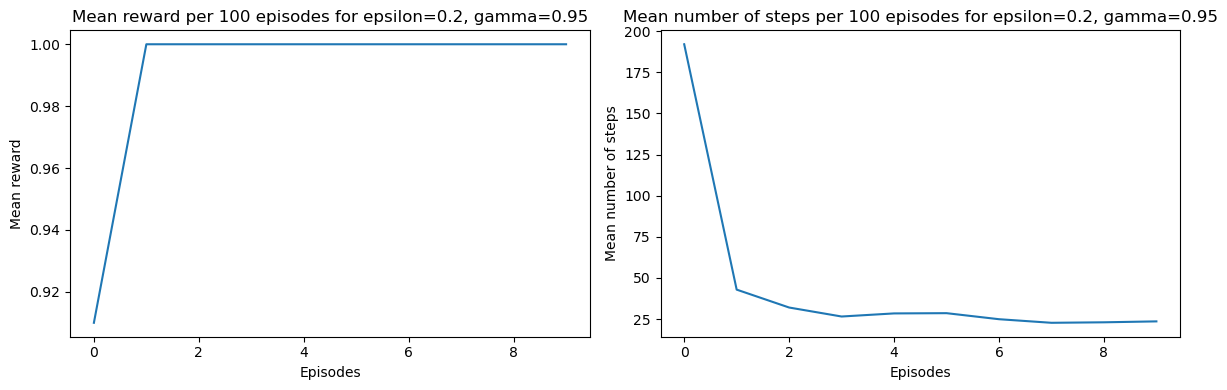

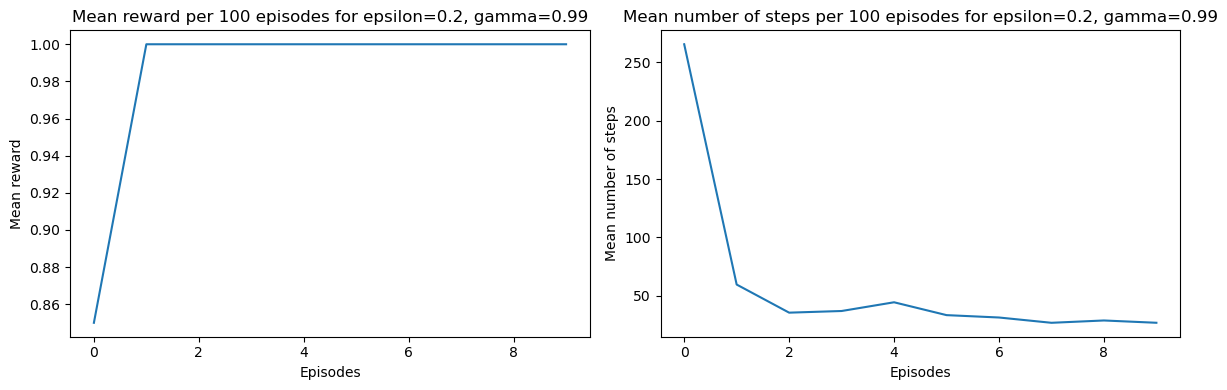

In [17]:
# for each combination of epsilon and gamma, plot the reward history and number of steps history
for (epsilon, gamma) in reward_historys.keys():
    avg_reward_history = mean_list(reward_historys[(epsilon, gamma)], 100)
    avg_num_steps_history = mean_list(num_steps_historys[(epsilon, gamma)], 100)
    # plot side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(avg_reward_history)
    axes[0].set_title(f"Mean reward per 100 episodes for epsilon={epsilon}, gamma={gamma}")
    axes[0].set_xlabel('Episodes')
    axes[0].set_ylabel('Mean reward')
    axes[1].plot(avg_num_steps_history)
    axes[1].set_title(f"Mean number of steps per 100 episodes for epsilon={epsilon}, gamma={gamma}")
    axes[1].set_xlabel('Episodes')
    axes[1].set_ylabel('Mean number of steps')
    plt.tight_layout()
    plt.show()

## SARSA

In [9]:
# Function to implement the SARSA algorithm
def sarsa(env, num_episodes, epsilon, alpha, gamma=1.0, max_env_steps=1000, print_every=100):
    # init history and Q-table
    reward_history = []
    num_steps_history = []
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # loop over episodes
    for i in range(num_episodes):
        # reset the environment
        state = env.reset()[0]
        # get the hashed state
        hashed_state = hash_state(state)
        # get the action from the epsilon-greedy policy
        action = epsilon_greedy_policy(Q, hashed_state, epsilon, env.action_space.n)
        done = False
        total_reward = 0
        # loop over steps
        for t in range(max_env_steps):
            # take a step in the environment
            next_state, reward, done, _, _ = env.step(action)
            # add the reward to the total
            total_reward += reward
            # get the next hashed state
            next_hashed_state = hash_state(next_state)
            # get the next action from the epsilon-greedy policy
            next_action = epsilon_greedy_policy(Q, next_hashed_state, epsilon, env.action_space.n)
            # update the Q-table
            td_target = reward + gamma * Q[next_hashed_state][next_action] # curr target
            td_delta = td_target - Q[hashed_state][action] # curr delta
            Q[hashed_state][action] += alpha * td_delta # update
            # update the state and action
            state = next_state
            hashed_state = next_hashed_state
            action = next_action
            # if done, break
            if done:
                break
        # append the total reward to the reward history
        reward_history.append(total_reward)
        num_steps_history.append(t)
        # Print out the total reward every 100 episodes
        if i % print_every == 0:
            print(f"\rEpisode {i}/{num_episodes}. Avg reward: {np.mean(reward_history[-print_every:])}, Avg steps: {np.mean(num_steps_history[-print_every:])}", end="")
            sys.stdout.flush()
            
    # return the Q-table and the reward history
    policy = {state: np.argmax(values) for state, values in Q.items()}
    return policy, Q, reward_history, num_steps_history


SARSA basic test

Episode 900/1000. Avg reward: 1.0, Avg steps: 15.6982

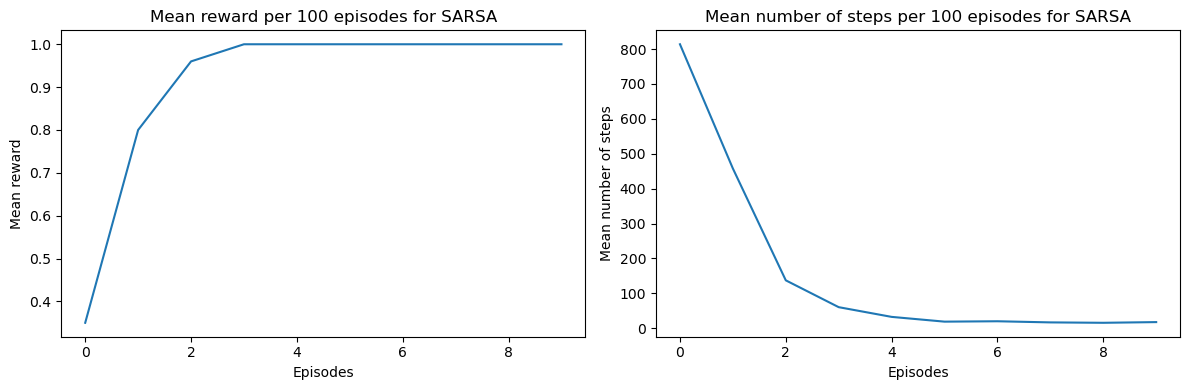

In [10]:
env = SimFlatObsWrapper(RandomEmptyEnv_10 (render_mode='rgb_array'))
# set the number of episodes 
num_episodes = 1000
max_steps = 1000

# test SARSA with basic parameters
epsilon = 0.2
alpha = 0.1
gamma = 0.95
policy_sarsa_empty, Q_sarsa_empty, reward_history_sarsa_empty, num_steps_history_sarsa_empty = sarsa(env, num_episodes, epsilon, alpha, gamma, max_steps)

# plot the reward history and number of steps history
avg_reward_history_sarsa_empty = mean_list(reward_history_sarsa_empty, 100)
avg_num_steps_history_sarsa_empty = mean_list(num_steps_history_sarsa_empty, 100)

# plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(avg_reward_history_sarsa_empty)
axes[0].set_title(f"Mean reward per 100 episodes for SARSA")
axes[0].set_xlabel('Episodes')
axes[0].set_ylabel('Mean reward')
axes[1].plot(avg_num_steps_history_sarsa_empty)
axes[1].set_title(f"Mean number of steps per 100 episodes for SARSA")
axes[1].set_xlabel('Episodes')
axes[1].set_ylabel('Mean number of steps')
plt.tight_layout()
plt.show()





## Q-Learning

In [11]:
# Function to implement the Q-learning algorithm (like SARSA but with max over next state-action pairs)
def q_learning(env, num_episodes, epsilon, alpha, gamma=1.0, max_env_steps=1000, print_every=100):
    # init history and Q-table
    reward_history = []
    num_steps_history = []
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # loop over episodes
    for i in range(num_episodes):
        # reset the environment
        state = env.reset()[0]
        # get the hashed state
        hashed_state = hash_state(state)
        done = False
        total_reward = 0
        # loop over steps
        for t in range(max_env_steps):
            # get the action from the epsilon-greedy policy
            action = epsilon_greedy_policy(Q, hashed_state, epsilon, env.action_space.n)
            # take a step in the environment
            next_state, reward, done, _, _ = env.step(action)
            # add the reward to the total
            total_reward += reward
            # get the next hashed state
            next_hashed_state = hash_state(next_state)
            # update the Q-table
            best_next_action = np.argmax(Q[next_hashed_state]) # best action
            td_target = reward + gamma * Q[next_hashed_state][best_next_action] # curr target
            td_delta = td_target - Q[hashed_state][action] # curr delta
            Q[hashed_state][action] += alpha * td_delta # update
            # update the state
            state = next_state
            hashed_state = next_hashed_state
            # if done, break
            if done:
                break
        # append the total reward to the reward history
        reward_history.append(total_reward)
        num_steps_history.append(t)
        # Print out the total reward every 100 episodes
        if i % print_every == 0:
            print(f"\rEpisode {i}/{num_episodes}. Avg reward: {np.mean(reward_history[-print_every:])}, Avg steps: {np.mean(num_steps_history[-print_every:])}", end="")
            sys.stdout.flush()

    # return the Q-table and the reward history
    policy = {state: np.argmax(values) for state, values in Q.items()}
    return policy, Q, reward_history, num_steps_history

Q-Learning basic test

Episode 900/1000. Avg reward: 1.0, Avg steps: 17.9851

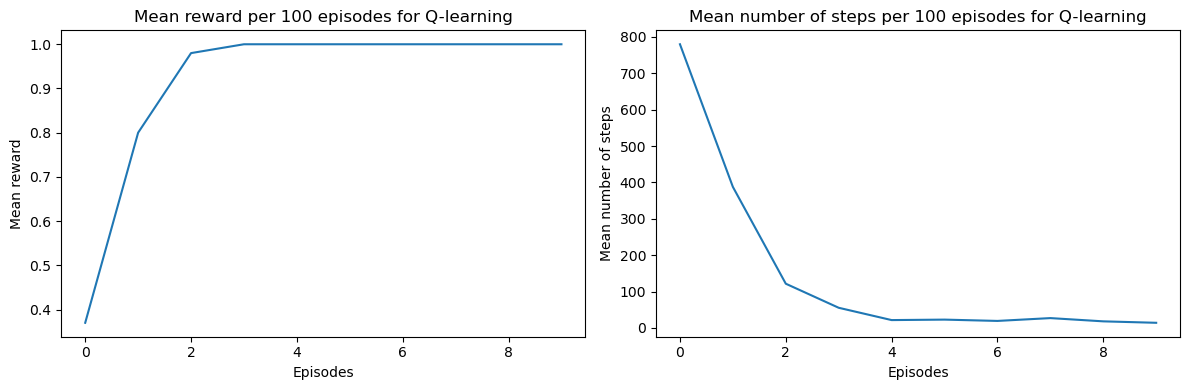

In [12]:
env = SimFlatObsWrapper(RandomEmptyEnv_10 (render_mode='rgb_array'))
# set the number of episodes
num_episodes = 1000
max_steps = 1000

# test Q-learning with basic parameters
epsilon = 0.2
alpha = 0.1
gamma = 0.95
policy_q_learning_empty, Q_q_learning_empty, reward_history_q_learning_empty, num_steps_history_q_learning_empty = q_learning(env, num_episodes, epsilon, alpha, gamma, max_steps)

# plot the reward history and number of steps history
avg_reward_history_q_learning_empty = mean_list(reward_history_q_learning_empty, 100)
avg_num_steps_history_q_learning_empty = mean_list(num_steps_history_q_learning_empty, 100)

# plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(avg_reward_history_q_learning_empty)
axes[0].set_title(f"Mean reward per 100 episodes for Q-learning")
axes[0].set_xlabel('Episodes')
axes[0].set_ylabel('Mean reward')
axes[1].plot(avg_num_steps_history_q_learning_empty)
axes[1].set_title(f"Mean number of steps per 100 episodes for Q-learning")
axes[1].set_xlabel('Episodes')
axes[1].set_ylabel('Mean number of steps')
plt.tight_layout()
plt.show()


# Best Model Selection and Evaluation for Empty Environment

In [15]:
# given policy_mc_empty, policy_sarsa_empty, policy_q_learning_empty, choose the best policy. we simulate the game for 1000 episodes and compare the average reward and average number of steps for each policy
num_episodes = 1000
max_steps = 1000

mc_reward_history = []
mc_steps_history = []
sarsa_reward_history = []
sarsa_steps_history = []
q_learning_reward_history = []
q_learning_steps_history = []

# simulate the game for 1000 episodes and compare the average reward and average number of steps for each policy
for i in range(num_episodes):
    done, total_reward, num_steps = infer_goal(env, best_policy_mc_empty, max_steps, show_init_state=False)
    mc_reward_history.append(total_reward)
    mc_steps_history.append(num_steps)
    done, total_reward, num_steps = infer_goal(env, policy_sarsa_empty, max_steps, show_init_state=False)
    sarsa_reward_history.append(total_reward)
    sarsa_steps_history.append(num_steps)
    done, total_reward, num_steps = infer_goal(env, policy_q_learning_empty, max_steps, show_init_state=False)
    q_learning_reward_history.append(total_reward)
    q_learning_steps_history.append(num_steps)

avg_mc_reward = np.mean(mc_reward_history)
avg_mc_steps = np.mean(mc_steps_history)
avg_sarsa_reward = np.mean(sarsa_reward_history)
avg_sarsa_steps = np.mean(sarsa_steps_history)
avg_q_learning_reward = np.mean(q_learning_reward_history)
avg_q_learning_steps = np.mean(q_learning_steps_history)

print(f"MC: Avg reward: {avg_mc_reward}, Avg steps: {avg_mc_steps}")
print(f"SARSA: Avg reward: {avg_sarsa_reward}, Avg steps: {avg_sarsa_steps}")
print(f"Q-learning: Avg reward: {avg_q_learning_reward}, Avg steps: {avg_q_learning_steps}")


MC: Avg reward: 0.904, Avg steps: 107.472
SARSA: Avg reward: 1.0, Avg steps: 10.491
Q-learning: Avg reward: 1.0, Avg steps: 10.645
